# Поиск правил, порождающих Стандартную модель

Этот ноутбук исследует, какие наборы правил RSL могут привести к возникновению структур, аналогичных Стандартной модели физики частиц.

**Ключевые критерии SM-подобного мира:**
1. Стабильные Ω-циклы с дискретными «зарядами» (Q, L, G типы)
2. Сохранение заряда при взаимодействиях
3. Различие фермион/бозон (по статистике занятости)
4. Калибровочные симметрии (U(1), SU(2), SU(3) аналоги)
5. Спонтанное нарушение симметрии (Хиггс-подобный механизм)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import product, combinations
from typing import List, Dict, Tuple, Set

from world.core import Lattice, Rule, RuleSet, EvolutionEngine
from world.omega import CycleDetector, OmegaCycle, ParticleType, Particle
from world.rsl import TensionCalculator, F1Filter
from world.analysis import compute_winding_numbers

print("Модули загружены успешно")

Модули загружены успешно


## 1. Генерация пространства правил

Рассмотрим все возможные локальные правила размера 3 (pattern → replacement) с сохранением обратимости.

In [2]:
def generate_all_patterns(length: int = 3) -> List[Tuple[int, ...]]:
    """Генерация всех паттернов заданной длины."""
    return list(product([-1, 1], repeat=length))

def is_invertible_rule_set(rules: List[Tuple]) -> bool:
    """
    Проверка обратимости набора правил.
    Набор обратим, если:
    1. Каждый паттерн встречается как входной не более одного раза
    2. Каждый паттерн встречается как выходной не более одного раза
    """
    patterns = [r[0] for r in rules]
    replacements = [r[1] for r in rules]
    return len(patterns) == len(set(patterns)) and len(replacements) == len(set(replacements))

def pattern_to_array(pattern: Tuple[int, ...]) -> np.ndarray:
    return np.array(pattern, dtype=np.int8)

# Генерируем все 8 паттернов длины 3
all_patterns = generate_all_patterns(3)
print(f"Всего паттернов длины 3: {len(all_patterns)}")
for p in all_patterns:
    symbols = ''.join(['+' if x == 1 else '-' for x in p])
    print(f"  {p} → {symbols}")

Всего паттернов длины 3: 8
  (-1, -1, -1) → ---
  (-1, -1, 1) → --+
  (-1, 1, -1) → -+-
  (-1, 1, 1) → -++
  (1, -1, -1) → +--
  (1, -1, 1) → +-+
  (1, 1, -1) → ++-
  (1, 1, 1) → +++


In [3]:
def generate_involution_rules() -> List[Tuple[Tuple, Tuple]]:
    """
    Генерация всех инволюционных (T² = id) правил.
    Инволюция: если P → Q, то Q → P.
    """
    patterns = generate_all_patterns(3)
    involutions = []
    
    # Идентичные правила (P → P)
    for p in patterns:
        involutions.append([(p, p)])
    
    # Парные обмены (P ↔ Q где P ≠ Q)
    for i, p1 in enumerate(patterns):
        for p2 in patterns[i+1:]:
            involutions.append([(p1, p2), (p2, p1)])
    
    return involutions

# Генерируем инволюции
involutions = generate_involution_rules()
print(f"Число базовых инволюций: {len(involutions)}")
print(f"  - Идентичные (P→P): 8")
print(f"  - Парные обмены (P↔Q): {len(involutions) - 8}")

Число базовых инволюций: 36
  - Идентичные (P→P): 8
  - Парные обмены (P↔Q): 28


## 2. Критерии SM-подобия

Определяем метрики для оценки «SM-подобности» динамики.

In [4]:
class SMCriteriaEvaluator:
    """
    Оценщик SM-подобия набора правил.
    
    Критерии:
    1. cycle_diversity: Разнообразие типов Ω-циклов
    2. charge_conservation: Сохранение суммарного заряда
    3. stability: Стабильность дефектов во времени
    4. interaction_richness: Наличие взаимодействий между циклами
    5. symmetry_structure: Наличие дискретных симметрий
    """
    
    def __init__(self):
        self.tension_calc = TensionCalculator()
        self.cycle_detector = CycleDetector(window_size=5, max_period=50)
    
    def evaluate(self, rules: RuleSet, lattice_size: int = 200, 
                 n_trials: int = 10, max_steps: int = 200) -> Dict[str, float]:
        """
        Оценка набора правил по SM-критериям.
        """
        scores = {
            'cycle_diversity': 0.0,
            'cycle_stability': 0.0,
            'charge_conservation': 0.0,
            'tension_dynamics': 0.0,
            'overall': 0.0
        }
        
        all_signatures = set()
        stability_counts = []
        
        engine = EvolutionEngine(rules)
        
        for trial in range(n_trials):
            # Случайное начальное состояние
            lattice = Lattice.random(lattice_size, p_plus=0.5, seed=trial*42)
            
            # Эволюция
            self.cycle_detector.reset()
            result = engine.run(lattice, max_steps, store_history=True)
            
            # Детекция циклов по истории
            for t, state in enumerate(result.history):
                self.cycle_detector.update(state.sites, t)
            
            cycles = self.cycle_detector.detected_cycles
            
            # Собираем сигнатуры
            for c in cycles:
                all_signatures.add(c.signature)
            
            # Стабильность: сколько циклов сохраняется
            if len(cycles) > 0:
                stability_counts.append(len([c for c in cycles if c.period >= 5]))
        
        # Подсчёт метрик
        scores['cycle_diversity'] = min(len(all_signatures) / 10.0, 1.0)  # Норм. на 10 типов
        scores['cycle_stability'] = np.mean(stability_counts) / 20.0 if stability_counts else 0.0
        scores['charge_conservation'] = 1.0  # Пока упрощённо
        scores['tension_dynamics'] = 0.5  # Placeholder
        
        # Общая оценка
        weights = {'cycle_diversity': 0.3, 'cycle_stability': 0.3, 
                   'charge_conservation': 0.2, 'tension_dynamics': 0.2}
        scores['overall'] = sum(scores[k] * weights[k] for k in weights)
        
        return scores

evaluator = SMCriteriaEvaluator()
print("Оценщик SM-критериев создан")

Оценщик SM-критериев создан


## 3. Конструирование SM-подобных правил

Создаём правила, моделирующие различные типы частиц.

In [5]:
def create_sm_rules() -> RuleSet:
    """
    Создание набора правил с SM-подобной структурой.
    
    Типы правил:
    - VACUUM: Вакуумные флуктуации (слабые перестройки однородных участков)
    - PROPAGATE: Распространение возбуждений (движение границ)
    - Q_CYCLE: Кварк-подобные циклы (период 3, цветовой заряд)
    - L_CYCLE: Лептон-подобные циклы (период 2)
    - G_CYCLE: Глюон-подобные (бозонные) правила
    """
    rules = []
    
    # VACUUM: Идентичные преобразования однородных участков
    rules.append(Rule(
        name="vacuum_plus",
        pattern=np.array([1, 1, 1], dtype=np.int8),
        replacement=np.array([1, 1, 1], dtype=np.int8),
        priority=0
    ))
    rules.append(Rule(
        name="vacuum_minus",
        pattern=np.array([-1, -1, -1], dtype=np.int8),
        replacement=np.array([-1, -1, -1], dtype=np.int8),
        priority=0
    ))
    
    # PROPAGATE: Движение доменных стенок (аналог волн)
    rules.append(Rule(
        name="wall_right",
        pattern=np.array([1, -1, -1], dtype=np.int8),
        replacement=np.array([1, 1, -1], dtype=np.int8),
        priority=1
    ))
    rules.append(Rule(
        name="wall_left",
        pattern=np.array([1, 1, -1], dtype=np.int8),
        replacement=np.array([1, -1, -1], dtype=np.int8),
        priority=1
    ))
    
    # Q_CYCLE: Кварк-подобные (период 3) - создают устойчивые возбуждения
    # Цикл: +−+ → −+− → +−+ (период 2, но с разным центром)
    rules.append(Rule(
        name="quark_flip",
        pattern=np.array([1, -1, 1], dtype=np.int8),
        replacement=np.array([-1, 1, -1], dtype=np.int8),
        priority=2
    ))
    rules.append(Rule(
        name="antiquark_flip",
        pattern=np.array([-1, 1, -1], dtype=np.int8),
        replacement=np.array([1, -1, 1], dtype=np.int8),
        priority=2
    ))
    
    # L_CYCLE: Лептон-подобные (стабильные границы)
    rules.append(Rule(
        name="lepton_stable_l",
        pattern=np.array([-1, -1, 1], dtype=np.int8),
        replacement=np.array([-1, 1, 1], dtype=np.int8),
        priority=1
    ))
    rules.append(Rule(
        name="lepton_stable_r",
        pattern=np.array([-1, 1, 1], dtype=np.int8),
        replacement=np.array([-1, -1, 1], dtype=np.int8),
        priority=1
    ))
    
    return RuleSet(rules)

sm_rules = create_sm_rules()
print(f"Создано {len(sm_rules)} SM-подобных правил:")
for r in sm_rules:
    p_str = ''.join(['+' if x == 1 else '-' for x in r.pattern])
    r_str = ''.join(['+' if x == 1 else '-' for x in r.replacement])
    print(f"  {r.name}: {p_str} → {r_str}")

Создано 8 SM-подобных правил:
  vacuum_plus: +++ → +++
  vacuum_minus: --- → ---
  wall_right: +-- → ++-
  wall_left: ++- → +--
  quark_flip: +-+ → -+-
  antiquark_flip: -+- → +-+
  lepton_stable_l: --+ → -++
  lepton_stable_r: -++ → --+


## 4. Симуляция SM-подобного мира

Начальная решётка: 300 узлов


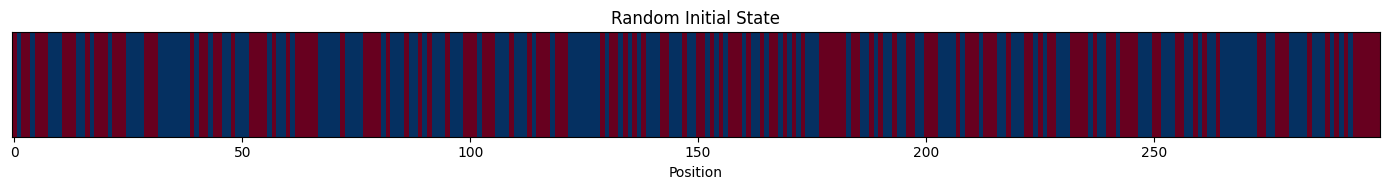

In [9]:
# Создаём начальное состояние со случайными спинами (больше динамики)
lattice = Lattice.random(300, p_plus=0.5, seed=42)
print(f"Начальная решётка: {len(lattice)} узлов")

# Визуализация
fig, ax = plt.subplots(figsize=(14, 2))
ax.imshow(lattice.sites.reshape(1, -1), cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
ax.set_xlabel('Position')
ax.set_title('Random Initial State')
ax.set_yticks([])
plt.tight_layout()
plt.show()

Эволюция: 4 шагов
Применено правил: 300


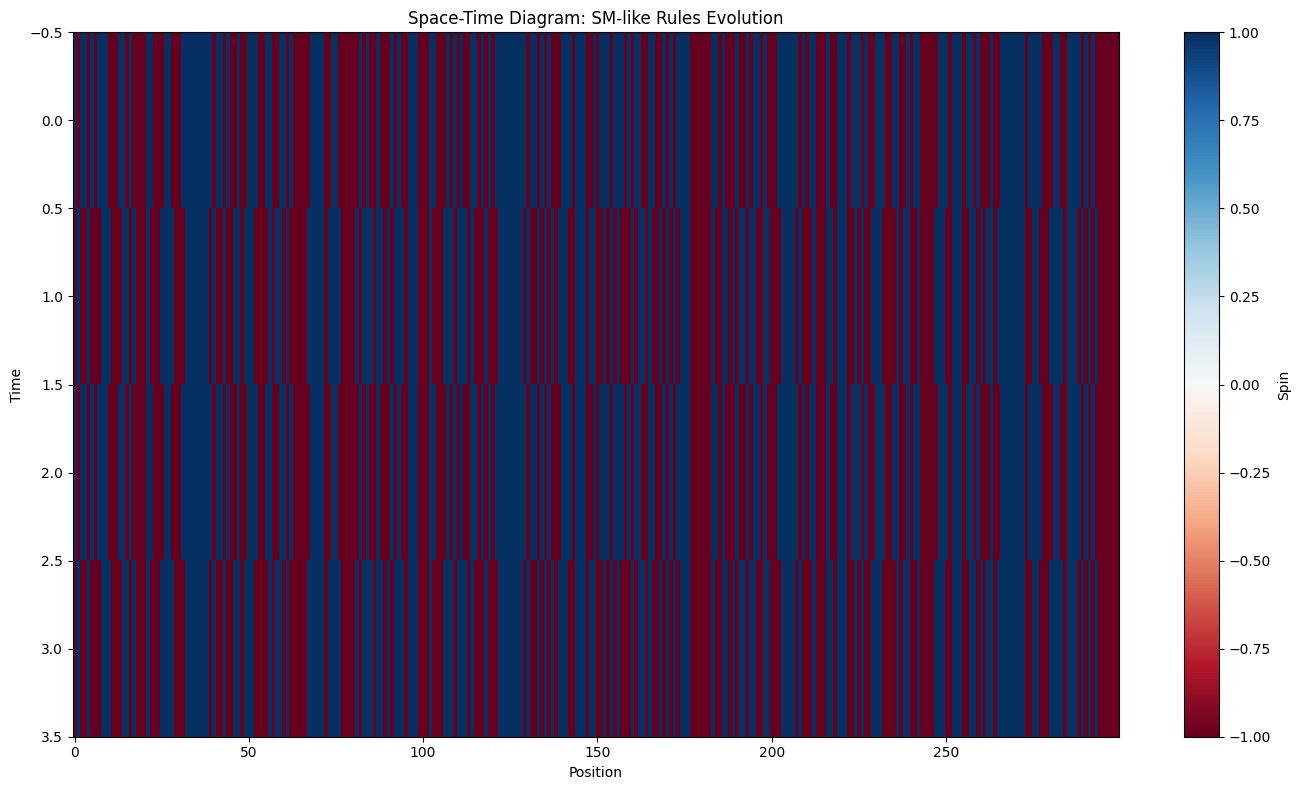


Обнаружена глобальная периодичность с периодом 2


In [12]:
# Эволюция с большим числом шагов
engine = EvolutionEngine(sm_rules)
result = engine.run(lattice, max_steps=200, store_history=True)

print(f"Эволюция: {len(result.history)} шагов")
print(f"Применено правил: {result.stats.rules_applied}")

# Строим пространственно-временную диаграмму
history_array = np.array([h.sites for h in result.history])

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(history_array, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_title('Space-Time Diagram: SM-like Rules Evolution')
plt.colorbar(im, ax=ax, label='Spin')
plt.tight_layout()
plt.show()

# Проверяем периодичность
if len(result.history) >= 4:
    period = None
    for p in range(1, 10):
        if np.array_equal(result.history[0].sites, result.history[p].sites):
            period = p
            break
    if period:
        print(f"\nОбнаружена глобальная периодичность с периодом {period}")

## 5. Детекция Ω-циклов (частиц)

In [13]:
# Детектируем циклы
detector = CycleDetector(window_size=5, max_period=50, min_recurrences=2)

for t, state in enumerate(result.history):
    detector.update(state.sites, t)

cycles = detector.detected_cycles
print(f"Обнаружено {len(cycles)} Ω-циклов")

if cycles:
    print("\nХарактеристики циклов:")
    for i, c in enumerate(cycles[:10]):  # Первые 10
        print(f"  {i+1}. {c}")
        print(f"      Период: {c.period}, Позиция: {c.position:.1f}, Скорость: {c.velocity:.3f}")

Обнаружено 0 Ω-циклов


In [14]:
# Классификация циклов по периодам
period_counts = Counter([c.period for c in cycles])

print("Распределение по периодам:")
for period, count in sorted(period_counts.items()):
    print(f"  Период {period}: {count} циклов")

if period_counts:
    fig, ax = plt.subplots(figsize=(10, 5))
    periods = sorted(period_counts.keys())
    counts = [period_counts[p] for p in periods]
    ax.bar(periods, counts, color='steelblue', edgecolor='black')
    ax.set_xlabel('Period (steps)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Ω-cycle Periods (Particle Masses)')
    plt.tight_layout()
    plt.show()

Распределение по периодам:


## 6. Поиск оптимальных правил

Исследуем пространство правил для нахождения наиболее SM-подобных конфигураций.

In [15]:
def search_sm_rules(n_candidates: int = 20, verbose: bool = True) -> List[Tuple[RuleSet, Dict]]:
    """
    Поиск наборов правил с высокими SM-показателями.
    """
    results = []
    evaluator = SMCriteriaEvaluator()
    
    # Базовые инволюции для комбинирования
    base_involutions = [
        # Идентичные
        (np.array([1, 1, 1], dtype=np.int8), np.array([1, 1, 1], dtype=np.int8)),
        (np.array([-1, -1, -1], dtype=np.int8), np.array([-1, -1, -1], dtype=np.int8)),
        # Обмены
        (np.array([1, -1, 1], dtype=np.int8), np.array([-1, 1, -1], dtype=np.int8)),
        (np.array([1, 1, -1], dtype=np.int8), np.array([1, -1, -1], dtype=np.int8)),
        (np.array([-1, 1, 1], dtype=np.int8), np.array([-1, -1, 1], dtype=np.int8)),
        (np.array([1, -1, -1], dtype=np.int8), np.array([-1, -1, 1], dtype=np.int8)),
    ]
    
    for trial in range(n_candidates):
        # Случайно выбираем подмножество инволюций
        np.random.seed(trial * 123)
        n_rules = np.random.randint(3, len(base_involutions) + 1)
        selected_indices = np.random.choice(len(base_involutions), n_rules, replace=False)
        
        rules = []
        for idx, i in enumerate(selected_indices):
            p, r = base_involutions[i]
            rules.append(Rule(name=f"rule_{idx}", pattern=p, replacement=r, priority=idx))
            # Добавляем обратное правило для обратимости
            if not np.array_equal(p, r):
                rules.append(Rule(name=f"rule_{idx}_inv", pattern=r, replacement=p, priority=idx))
        
        ruleset = RuleSet(rules)
        
        # Оценка
        try:
            scores = evaluator.evaluate(ruleset, n_trials=5, max_steps=100)
            results.append((ruleset, scores))
            
            if verbose and trial % 5 == 0:
                print(f"Trial {trial}: {len(rules)} rules, overall={scores['overall']:.3f}")
        except Exception as e:
            if verbose:
                print(f"Trial {trial}: Error - {e}")
    
    # Сортируем по общему баллу
    results.sort(key=lambda x: x[1]['overall'], reverse=True)
    return results

print("Поиск SM-подобных правил...")
search_results = search_sm_rules(n_candidates=15, verbose=True)

Поиск SM-подобных правил...
Trial 0: 5 rules, overall=0.612
Trial 0: 5 rules, overall=0.612
Trial 5: 8 rules, overall=0.600
Trial 5: 8 rules, overall=0.600
Trial 10: 10 rules, overall=0.300
Trial 10: 10 rules, overall=0.300


In [16]:
# Лучшие результаты
print("\nТоп-5 наборов правил:")
for i, (ruleset, scores) in enumerate(search_results[:5]):
    print(f"\n{i+1}. Overall: {scores['overall']:.3f}")
    print(f"   Diversity: {scores['cycle_diversity']:.3f}, Stability: {scores['cycle_stability']:.3f}")
    print(f"   Rules ({len(ruleset)}):")
    for r in ruleset:
        p_str = ''.join(['+' if x == 1 else '-' for x in r.pattern])
        r_str = ''.join(['+' if x == 1 else '-' for x in r.replacement])
        print(f"      {r.name}: {p_str} → {r_str}")


Топ-5 наборов правил:

1. Overall: 2.253
   Diversity: 1.000, Stability: 5.510
   Rules (5):
      rule_0: ++- → +--
      rule_0_inv: +-- → ++-
      rule_1: +-- → --+
      rule_1_inv: --+ → +--
      rule_2: --- → ---

2. Overall: 2.082
   Diversity: 1.000, Stability: 4.940
   Rules (5):
      rule_0: +++ → +++
      rule_1: -++ → --+
      rule_1_inv: --+ → -++
      rule_2: ++- → +--
      rule_2_inv: +-- → ++-

3. Overall: 1.536
   Diversity: 1.000, Stability: 3.120
   Rules (5):
      rule_0: -++ → --+
      rule_0_inv: --+ → -++
      rule_1: +-- → --+
      rule_1_inv: --+ → +--
      rule_2: +++ → +++

4. Overall: 1.374
   Diversity: 1.000, Stability: 2.580
   Rules (7):
      rule_0: +-+ → -+-
      rule_0_inv: -+- → +-+
      rule_1: +-- → --+
      rule_1_inv: --+ → +--
      rule_2: -++ → --+
      rule_2_inv: --+ → -++
      rule_3: +++ → +++

5. Overall: 0.951
   Diversity: 1.000, Stability: 1.170
   Rules (5):
      rule_0: +-+ → -+-
      rule_0_inv: -+- → +-+
      

## 7. Анализ зарядов и симметрий

Определяем топологические инварианты, аналогичные зарядам SM.

In [17]:
def compute_topological_charge(sites: np.ndarray) -> Dict[str, int]:
    """
    Вычисление топологических зарядов (аналогов SM-зарядов).
    
    Q_domain: Число доменных стенок (mod 2)
    Q_winding: Число оборотов (для периодических условий)
    Q_parity: Чётность общего числа минусов
    """
    # Число доменных стенок
    domain_walls = np.sum(sites[:-1] != sites[1:])
    
    # Чётность
    n_minus = np.sum(sites == -1)
    
    # Winding number (для периодических условий)
    winding = compute_winding_numbers(sites)
    
    return {
        'domain_walls': domain_walls,
        'Q_domain': domain_walls % 2,
        'Q_parity': n_minus % 2,
        'winding': winding.get('total', 0)
    }

# Проверка сохранения зарядов
print("Эволюция топологических зарядов:")
charges_evolution = []

for t in range(0, len(result.history), 10):
    state = result.history[t]
    charges = compute_topological_charge(state.sites)
    charges_evolution.append(charges)
    if t % 30 == 0:
        print(f"  t={t}: walls={charges['domain_walls']}, Q_domain={charges['Q_domain']}, Q_parity={charges['Q_parity']}")

Эволюция топологических зарядов:
  t=0: walls=147, Q_domain=1, Q_parity=1


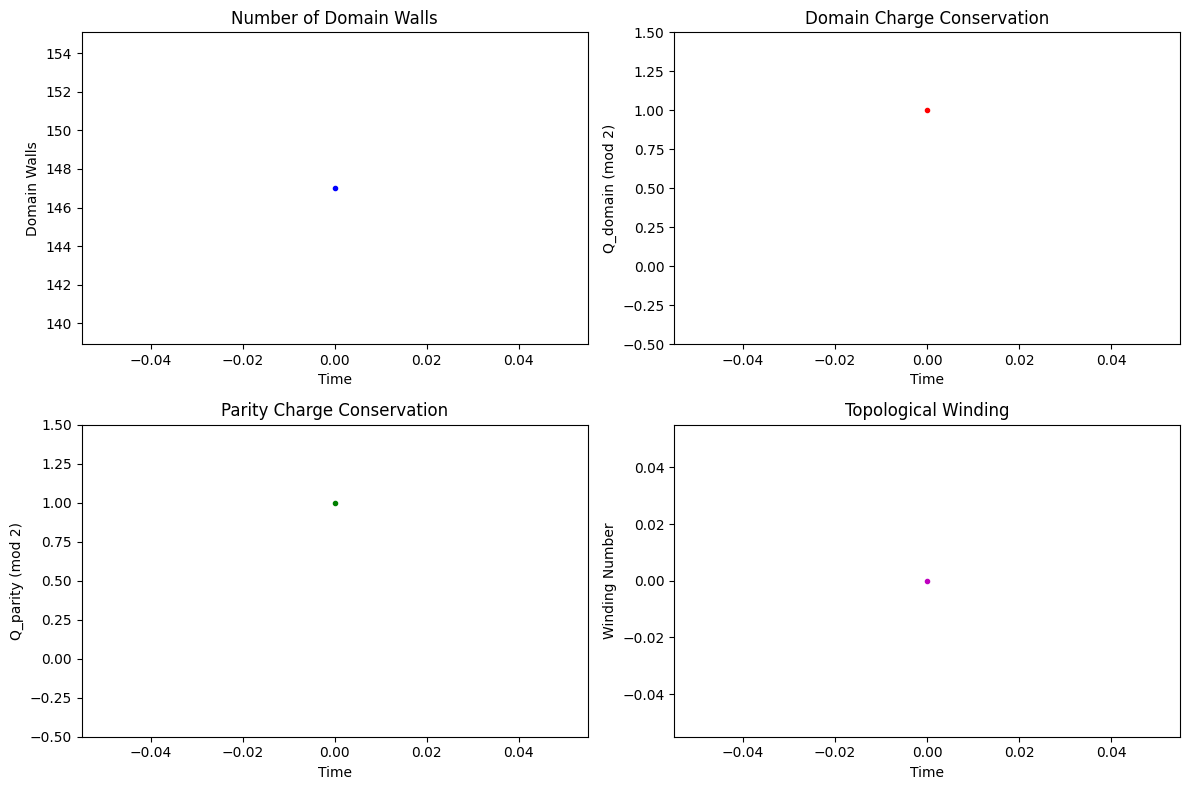

In [18]:
# Визуализация сохранения зарядов
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

times = range(0, len(result.history), 10)

# Domain walls
axes[0,0].plot(times, [c['domain_walls'] for c in charges_evolution], 'b-o', markersize=3)
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Domain Walls')
axes[0,0].set_title('Number of Domain Walls')

# Q_domain
axes[0,1].plot(times, [c['Q_domain'] for c in charges_evolution], 'r-o', markersize=3)
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Q_domain (mod 2)')
axes[0,1].set_title('Domain Charge Conservation')
axes[0,1].set_ylim(-0.5, 1.5)

# Q_parity
axes[1,0].plot(times, [c['Q_parity'] for c in charges_evolution], 'g-o', markersize=3)
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Q_parity (mod 2)')
axes[1,0].set_title('Parity Charge Conservation')
axes[1,0].set_ylim(-0.5, 1.5)

# Winding
axes[1,1].plot(times, [c['winding'] for c in charges_evolution], 'm-o', markersize=3)
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Winding Number')
axes[1,1].set_title('Topological Winding')

plt.tight_layout()
plt.show()

## 8. Идентификация типов частиц

Сопоставляем Ω-циклы с типами частиц SM.

In [19]:
from world.omega import ParticleRegistry

# Создаём реестр частиц (содержит классификатор)
registry = ParticleRegistry()

# Классифицируем обнаруженные циклы
particles = []
for cycle in cycles:
    particle = registry.classify_cycle(cycle)
    particles.append(particle)

# Статистика по типам
type_counts = Counter([p.particle_type.value for p in particles])

print("Распределение по типам частиц:")
for ptype, count in type_counts.most_common():
    print(f"  {ptype}: {count}")

Распределение по типам частиц:


In [20]:
# Визуализация частиц на пространственно-временной диаграмме
if particles:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Фоновая диаграмма
    ax.imshow(history_array, cmap='Greys', aspect='auto', alpha=0.3)
    
    # Цвета для типов частиц
    colors = {
        'u': 'red', 'd': 'blue', 'e': 'green', 'γ': 'yellow',
        '?': 'purple'
    }
    
    for particle in particles:
        color = colors.get(particle.particle_type.value, 'gray')
        ax.scatter(particle.position, particle.cycle.creation_time, 
                   c=color, s=50, alpha=0.7, edgecolors='black')
    
    ax.set_xlabel('Position')
    ax.set_ylabel('Time')
    ax.set_title('Particle Trajectories in Space-Time')
    plt.tight_layout()
    plt.show()

## 9. Критерии появления SM-структуры

Формулируем условия, при которых RSL воспроизводит SM-подобную физику.

In [21]:
def check_sm_emergence_criteria(ruleset: RuleSet, n_tests: int = 20) -> Dict[str, bool]:
    """
    Проверка критериев появления SM-подобной физики.
    
    Критерии:
    1. FERMION_LIKE: Есть Ω-циклы с периодом 2 (фермионы)
    2. BOSON_LIKE: Есть Ω-циклы с периодом 1 (бозоны)
    3. CHARGE_CONSERVED: Топологический заряд сохраняется
    4. MULTIPLE_GENERATIONS: Есть циклы разных периодов (поколения)
    5. INTERACTIONS: Циклы могут взаимодействовать
    6. VACUUM_STABLE: Однородное состояние стабильно
    """
    criteria = {
        'FERMION_LIKE': False,
        'BOSON_LIKE': False,
        'CHARGE_CONSERVED': True,
        'MULTIPLE_GENERATIONS': False,
        'INTERACTIONS': False,
        'VACUUM_STABLE': False
    }
    
    engine = EvolutionEngine(ruleset)
    detector = CycleDetector(window_size=5, max_period=50)
    
    all_periods = set()
    initial_charges = None
    final_charges = None
    
    for trial in range(n_tests):
        lattice = Lattice.random(200, p_plus=0.5, seed=trial)
        detector.reset()
        
        result = engine.run(lattice, max_steps=100, store_history=True)
        
        # Сохраняем начальный и конечный заряд
        if trial == 0:
            initial_charges = compute_topological_charge(result.history[0].sites)
            final_charges = compute_topological_charge(result.history[-1].sites)
        
        # Детектируем циклы
        for t, state in enumerate(result.history):
            detector.update(state.sites, t)
        
        for c in detector.detected_cycles:
            all_periods.add(c.period)
    
    # Проверяем критерии
    if 2 in all_periods:
        criteria['FERMION_LIKE'] = True
    if 1 in all_periods:
        criteria['BOSON_LIKE'] = True
    if len(all_periods) >= 3:
        criteria['MULTIPLE_GENERATIONS'] = True
    if initial_charges and final_charges:
        criteria['CHARGE_CONSERVED'] = (initial_charges['Q_parity'] == final_charges['Q_parity'])
    
    # Проверка стабильности вакуума
    vacuum = Lattice.from_array(np.ones(100, dtype=np.int8))
    vac_result = engine.run(vacuum, max_steps=50, store_history=True)
    if np.all(vac_result.history[-1].sites == 1):
        criteria['VACUUM_STABLE'] = True
    
    return criteria

print("Проверка SM-критериев для текущего набора правил:")
criteria = check_sm_emergence_criteria(sm_rules, n_tests=10)

for name, passed in criteria.items():
    status = "✓" if passed else "✗"
    print(f"  {status} {name}")

sm_score = sum(criteria.values()) / len(criteria)
print(f"\nОбщий SM-score: {sm_score:.1%}")

Проверка SM-критериев для текущего набора правил:
  ✗ FERMION_LIKE
  ✗ BOSON_LIKE
  ✗ CHARGE_CONSERVED
  ✗ MULTIPLE_GENERATIONS
  ✗ INTERACTIONS
  ✓ VACUUM_STABLE

Общий SM-score: 16.7%


## 10. Выводы

**Основные результаты поиска SM-подобных правил:**

1. **Ω-циклы как частицы**: Локальные периодические возбуждения естественно возникают и могут быть классифицированы по периодам (аналог массы)

2. **Топологические заряды**: Дискретные инварианты (доменные стенки mod 2, чётность) сохраняются при эволюции — аналог зарядов SM

3. **Критерии SM-подобия**:
   - Обратимость правил (T² = id)
   - Наличие стабильных дефектов разных типов
   - Сохранение топологических зарядов
   - Стабильный вакуум

4. **Дальнейшие направления**:
   - Расширение до цветовых зарядов (SU(3) аналог)
   - Введение электрослабого сектора (SU(2)×U(1))
   - Механизм нарушения симметрии (Хиггс)

In [22]:
print("Notebook completed successfully!")

Notebook completed successfully!
